# ROB317 TP1 : Homographie
_Auteurs :_
* _Benjamin Ternot_
* _Cécile Tillerot_

## 1. Importation des librairies & fonctions utiles

In [1]:
import threading
import tkinter as tk

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown

In [2]:
#quelques fonctions permettenant d'afficher de manière plus esthétiques les tableaux numpy en markdown

def array_to_markdown(arr):
    if (arr.ndim==1):
        return r'\begin{pmatrix}' + ' & '.join([str(elem) for elem in arr]) + r'\end{pmatrix}'
    elif (arr.ndim ==2):
        latex_str = r'\begin{pmatrix}'
        for row in arr:
            latex_str += ' & '.join([str(elem) for elem in row])
            latex_str += r'\\'
        latex_str += r'\end{pmatrix}'
        return latex_str
    raise ValueError(f" array can not be display if it has {arr.ndim()} dimensions") 
def display_markdown(string):
    display(Markdown(string))

In [3]:
# Modifier les couleurs des textes et des axes en fonction du thème de Jupyter
DARK_BG = True

if DARK_BG:
    plt.rcParams['text.color'] = 'white'
    plt.rcParams['axes.labelcolor'] = 'white'
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'
    plt.rcParams['axes.titlecolor'] = 'white'
else:
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'

## 2. Estimation et correction d’une homographie

### Q1 : Dans quel cas la transformation entre deux images est-elle une homographie ?
> La transformation entre deux images est une homographie dans les deux cas suivants :
> - Les deux images représentent une scène 3D vue sous une rotation pure autour du centre optique.
> - Les deux images représentent le même plan vu sous deux poses 3D différentes.

### Q2 : Combien de points au minimum devez-vous sélectionner ?
> Nous devons sélectionner au minimum 4 points pour estimer une homographie. Une homographie est définie par une matrice \(3 \times 3\) avec 8 degrés de liberté (puisque la matrice est définie à un facteur de normalisation près). Chaque point correspond à deux équations, donc au moins 4 points sont nécessaires pour obtenir un système d'équations solvable.

### Q3 : Complétez le code. Pensez à normaliser vos coordonnées, puis à dé-normaliser la solution. Quel est l’intérêt de ce traitement ? Quel indice de confiance pouvez-vous utiliser pour évaluer la fiabilité du résultat fourni ?
> L'intérêt de la normalisation des coordonnées est de rendre le problème plus numériquement stable. En effet, les coordonnées des points peuvent être très grandes ou très petites, ce qui peut entraîner des erreurs d'arrondi lors de la résolution du système d'équations. En normalisant les coordonnées, nous nous assurons que les valeurs sont de l'ordre de grandeur de 1, ce qui améliore la stabilité numérique. 
> 
> Pour évaluer la fiabilité du résultat, nous pouvons utiliser la distance euclidienne moyenne entre les points correspondants dans les deux images. Si cette distance est très faible, cela signifie que l'homographie est une bonne approximation de la transformation entre les deux images.

#### Code de la classe `HomographyRectifier` :

In [4]:
class HomographyRectifier:
    """ Classe permettant de rectifier une image à l'aide d'une homographie et de points de correspondance """

    def __init__(self, image_path: str):
        """ Initialisation de la classe
        :param image_path: chemin vers le dossier contenant les images
        """
        
        self.img_path = image_path
        self.img = None
        self.img_with_points = None
        self.points_init = []
        self.points_final = []
        self.H: np.ndarray = None
        self.rectified_img = None
        self.rectified_img_with_points = None
        self.status = 1


    def open_img(self, image_name: str) -> np.ndarray:
        """ Ouvre une image et affiche ses dimensions
        :param image_name: nom de l'image à ouvrir
        :return: image
        """
        
        image = np.uint8(cv2.imread(self.img_path + image_name))
        print("Dimension de l'image {} : {} lignes x {} colonnes x {} couleurs".format(image_name, image.shape[0], image.shape[1], image.shape[2]))
        return image


    def select_points(self, image: np.ndarray, image_name: str, format_legend: str) -> tuple[int, np.ndarray, list[tuple[int, int]]]:
        """ Permet de sélectionner des points sur l'image initiale
        :param image: image à afficher
        :param image_name: nom de l'image
        :param format_legend: format de la légende des points
        :return: statut de l'opération, image avec points et points sélectionnés
        """
        
        image_with_points = image.copy()
        points_init = []
        window_name = f"Point selection on {image_name}"

        def mouse_callback(event: int, x: int, y: int, flags: int, params: any) -> None:
            """ Fonction de rappel pour la sélection des points
            :param event: type d'évènement
            :param x: coordonnée x du point sélectionné
            :param y: coordonnée y du point sélectionné
            :param flags: drapeaux d'événement
            :param params: paramètres supplémentaires
            """
            
            nonlocal image_with_points, points_init, format_legend
            if event == cv2.EVENT_LBUTTONDOWN:
                x_select, y_select = x, y
                points_init.append((x_select, y_select))
                cv2.circle(image_with_points, (x_select, y_select), 8, (0, 255, 255), 1)
                cv2.line(image_with_points, (x_select - 8, y_select), (x_select + 8, y_select), (0, 255, 0), 1)
                cv2.line(image_with_points, (x_select, y_select - 8), (x_select, y_select + 8), (0, 255, 0), 1)
                text = format_legend.format(len(points_init), x_select, y_select)
                text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                text_w, text_h = text_size
                text_x = max(0, min(x_select - text_w // 2, image_with_points.shape[1] - text_w))
                text_y = y_select - text_h if y_select - text_h > 0 else y_select + text_h
                cv2.putText(image_with_points, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)
            elif event == cv2.EVENT_RBUTTONDOWN:
                image_with_points = image.copy()
                points_init.clear()

        cv2.namedWindow(window_name)
        cv2.setMouseCallback(window_name, mouse_callback)
        while True:
            cv2.imshow(window_name, image_with_points)
            key = cv2.waitKey(1) & 0xFF
            if (key == ord("q") or key == 13) and len(points_init) >= 4:
                cv2.setMouseCallback(window_name, lambda *args: None)
                break
            elif key == 27:
                cv2.destroyAllWindows()
                return 0, image, []
            if cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE) < 1:
                cv2.destroyAllWindows()
                return 0, image, []
        points_init = np.asarray(points_init, dtype=np.float32)
        return 1, image_with_points, points_init


    @staticmethod
    def get_correspondences(points_init: np.ndarray) -> tuple[int, np.ndarray]:
        """ Permet de saisir les points de correspondance pour chaque point sélectionné dans une nouvelle fenêtre
        :param points_init: points sélectionnés sur l'image initiale
        :return: statut de l'opération et points de correspondance
        """
        
        status = 0
        root = tk.Tk()
        root.title("Correspondence Points")
        points_final = np.zeros((len(points_init), 2), np.float32)
        entries = []
        for i in range(len(points_init)):
            tk.Label(root, text=f"Point {i + 1}' (x y):").grid(row=i, column=0)
            x_entry = tk.Entry(root)
            y_entry = tk.Entry(root)
            x_entry.grid(row=i, column=1)
            y_entry.grid(row=i, column=2)
            entries.append((x_entry, y_entry))

        def on_submit(event=None):
            """ Fonction de rappel pour la soumission des points de correspondance """
            
            nonlocal status, entries, points_final
            for i, (x_entry, y_entry) in enumerate(entries):
                points_final[i] = [float(x_entry.get()), float(y_entry.get())]
            status = 1
            root.destroy()

        def on_cancel(event=None):
            """ Fonction de rappel pour l'annulation de la saisie des points de correspondance """
            
            nonlocal status
            status = 0
            cv2.destroyAllWindows()
            root.destroy()

        def validate_entries(*args):
            """ Fonction de validation des champs de saisie pour activer le bouton 'OK' """
            
            for x_entry, y_entry in entries:
                if not x_entry.get() or not y_entry.get():
                    submit_button.config(state=tk.DISABLED)
                    return
            submit_button.config(state=tk.NORMAL)

        for x_entry, y_entry in entries:
            x_entry.bind("<KeyRelease>", validate_entries)
            y_entry.bind("<KeyRelease>", validate_entries)

        button_frame = tk.Frame(root)
        button_frame.grid(row=len(points_init), column=0, columnspan=3, pady=10)
        cancel_button = tk.Button(button_frame, text="Cancel", command=on_cancel)
        cancel_button.pack(side=tk.LEFT, expand=True, fill=tk.X, padx=5)
        submit_button = tk.Button(button_frame, text="Submit", command=on_submit, state=tk.DISABLED)
        submit_button.pack(side=tk.RIGHT, expand=True, fill=tk.X, padx=5)
        root.bind('<Return>', on_submit)
        root.bind('<Escape>', on_cancel)
        root.protocol("WM_DELETE_WINDOW", on_cancel)
        root.mainloop()
        return status, points_final


    @staticmethod
    def estimate_H(points_init: np.ndarray, points_final: np.ndarray, normalize: bool) -> np.ndarray:
        """ Estime la matrice d'homographie à partir des points sélectionnés
        :param points_init: points sélectionnés sur l'image initiale
        :param points_final: points de correspondance sélectionnés sur l'image finale
        :param normalize: normalisation des coordonnées
        :return: matrice d'homographie estimée
        """
        
        if len(points_final) != len(points_init):
            raise ValueError("Le nombre de points correspondants ne correspond pas au nombre de points sélectionnés.")
        A = []
        for i in range(len(points_init)):
            x, y = points_init[i][0], points_init[i][1]
            xf, yf = points_final[i][0], points_final[i][1]
            A.append([-x, -y, -1, 0, 0, 0, x * xf, y * xf, xf])
            A.append([0, 0, 0, -x, -y, -1, x * yf, y * yf, yf])
        A = np.array(A)
        U, S, Vh = np.linalg.svd(A)
        H = Vh[-1].reshape(3, 3)
        
        if normalize:
            H = H / H[2, 2]
            
        return H


    @staticmethod
    def rectify_image(image: np.ndarray, H: np.ndarray) -> np.ndarray:
        """ Rectifie l'image à l'aide de la matrice d'homographie
        :param image: image à rectifier
        :param H: matrice d'homographie
        :return: image rectifiée
        """
        
        h, w = image.shape[:2]
        rectified_image = cv2.warpPerspective(image, H, (w, h))
        return rectified_image


    @staticmethod
    def draw_points_on_image(image: np.ndarray, points: np.ndarray) -> np.ndarray:
        """ Affiche les points de correspondance sur l'image
        :param image: image à afficher
        :param points: points de correspondance
        :return: image avec points
        """
        
        image_with_points = image.copy()
        for i, (x, y) in enumerate(points):
            cv2.circle(image_with_points, (int(x), int(y)), 8, (0, 255, 255), 1)
            cv2.line(image_with_points, (int(x) - 8, int(y)), (int(x) + 8, int(y)), (0, 255, 0), 1)
            cv2.line(image_with_points, (int(x), int(y) - 8), (int(x), int(y) + 8), (0, 255, 0), 1)
            text = f"Point {i + 1}' ({int(x)}, {int(y)})"
            text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            text_w, text_h = text_size
            text_x = max(0, min(int(x) - text_w // 2, image_with_points.shape[1] - text_w))
            text_y = int(y) - text_h if int(y) - text_h > 0 else int(y) + text_h
            cv2.putText(image_with_points, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)
        
        return image_with_points


    def view_image(self, image: np.ndarray, image_with_points: np.ndarray, image_name: str) -> None:
        """ Affiche l'image dans une nouvelle fenêtre
        :param image: image à afficher
        :param image_with_points: image avec points à afficher
        :param image_name: nom de l'image
        """
        
        show_points = False
        while True:
            display_image: np.ndarray = image_with_points if show_points else image
            cv2.imshow(image_name, display_image)
            k: int = cv2.waitKey(0)
            if k == ord("q") or cv2.getWindowProperty(image_name, cv2.WND_PROP_VISIBLE) < 1:
                cv2.destroyAllWindows()
                break
            elif k == ord("s"):
                cv2.imwrite(self.img_path + image_name + ("_with_points" if show_points else ""), display_image)
                cv2.destroyAllWindows()
                break
            elif k == ord("p"):
                show_points = not show_points


    @staticmethod
    def display_homography_parameters(points_init: np.ndarray, points_final: np.ndarray, H: np.ndarray, round_float: int) -> None:
        """ Affiche les paramètres de l'homographie
        :param points_init: points sélectionnés sur l'image initiale
        :param points_final: points de correspondance sélectionnés sur l'image finale
        :param H: matrice d'homographie estimée
        :param round_float: précision de l'arrondi
        """
        
        display_markdown("$$X_{init}=" + array_to_markdown(np.int16(points_init)) + "$$")
        display_markdown("$$X_{final}=" + array_to_markdown(np.int16(points_final)) + "$$")
        display_markdown("$$\\mathcal{H}\\approx" + array_to_markdown(np.round(H, round_float) if round_float else H) + "$$")


    @staticmethod
    def display_images_side_by_side(image1: np.ndarray, image2: np.ndarray, image_name1: str, image_name2: str) -> None:
        """ Affiche deux images côte à côte
        :param image1: première image à afficher
        :param image2: deuxième image à afficher
        :param image_name1: nom de la première image
        :param image_name2: nom de la deuxième image
        """
        
        plt.figure(figsize=(20, 10))
        
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
        plt.title(image_name1)
        plt.axis("off")
        
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
        plt.title(image_name2)
        plt.axis("off")
        
        plt.show()


    def open_and_rectify_img(self, img_name: str, normalize_H: bool=True, round_float: int = None) -> int:
        """ Ouvre une image, sélectionne les points de correspondance, estime l'homographie et rectifie l'image
        :param img_name: nom de l'image à ouvrir
        :param normalize_H: normalisation de la matrice d'homographie (par défaut)
        :param round_float: précision de l'arrondi pour l'affichage des paramètres de l'homographie
        :return: statut de l'opération
        """
        
        self.img = self.open_img(img_name)
        
        self.status, self.img_with_points, self.points_init = self.select_points(self.img, img_name, "Point {} ({}, {})")
        if self.status == 0:
            print("Opération annulée.")
            return 0
        
        self.status, self.points_final = self.get_correspondences(self.points_init)
        if self.status == 0:
            print("Opération annulée.")
            return 0
        
        self.H = self.estimate_H(self.points_init, self.points_final, normalize_H)
        
        self.rectified_img = self.rectify_image(self.img, self.H)
        
        self.rectified_img_with_points = self.draw_points_on_image(self.rectified_img, self.points_final)
        
        self.view_image(self.rectified_img, self.rectified_img_with_points, img_name + "_rectifiee")
        
        self.display_homography_parameters(self.points_init, self.points_final, self.H, round_float)
        
        self.display_images_side_by_side(self.img_with_points, self.rectified_img_with_points, img_name, img_name + " rectifiee")
        
        return self.status

In [5]:
# Creation d'une instance de la classe `HomographyRectifier`
rectifier = HomographyRectifier("./Images_Homographie/")

Dimension de l'image Pompei.jpg : 333 lignes x 500 colonnes x 3 couleurs


$$X_{init}=\begin{pmatrix}143 & 43\\112 & 255\\370 & 265\\356 & 44\\\end{pmatrix}$$

$$X_{final}=\begin{pmatrix}50 & 50\\50 & 250\\250 & 250\\250 & 50\\\end{pmatrix}$$

$$\mathcal{H}\approx\begin{pmatrix}1.05 & 0.21 & -104.99\\0.0 & 1.27 & -1.61\\0.0 & 0.0 & 1.0\\\end{pmatrix}$$

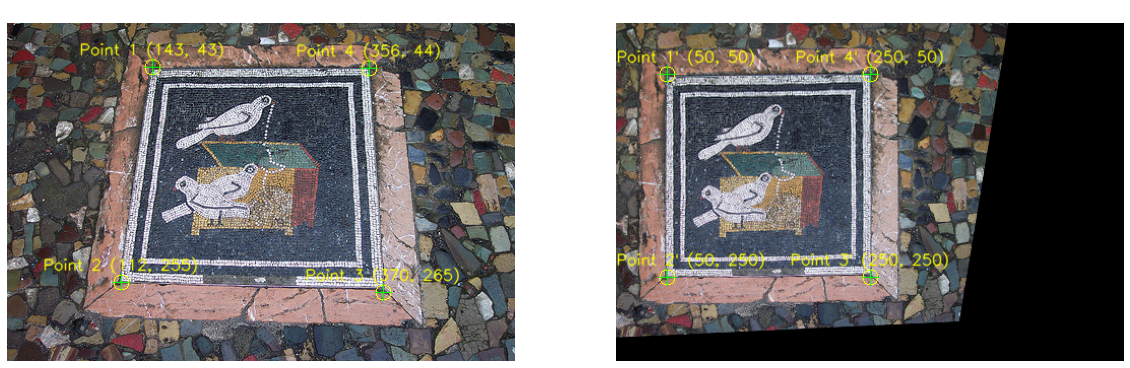

In [8]:
# Rectification de l'image "Pompei.jpg" avec normalisation de la matrice d'homographie
# Clic gauche pour sélectionner les points sur l'image
# Clic droit pour réinitialiser la sélection
# Entrée ou 'q' pour valider la sélection
# Echap pour annuler l'opération
# 'p' pour afficher/masquer les points de correspondance sur l'image rectifiée
# 's' pour sauvegarder l'image rectifiée
status = rectifier.open_and_rectify_img("Pompei.jpg", round_float=2)

## 3. Création de panorama

### Q4 : Modifier le script fourni afin de saisir les points par paires entre deux images, de façon à réaliser un panorama comme dans l’exemple de la Figure 2. Quelle condition doit respecter la prise de vue entre les deux images ? Comment retrouver les paramètres de cette transformation à partir de ceux de l’homographie ?
> Pour réaliser un panorama, les images doivent être prises avec un certain chevauchement, c'est-à-dire qu'une partie de la scène doit être visible dans les deux images. De plus, les images doivent être prises à partir du même point de vue ou avec une rotation minimale de la caméra pour éviter les distorsions.
> 
> Les paramètres de la transformation peuvent être retrouvés à partir de l'homographie en utilisant les points de correspondance entre les deux images. L'homographie permet de transformer les coordonnées des points de l'image source vers l'image cible, ce qui permet de les aligner correctement pour créer le panorama.

#### Code de la classe `PanoramaMaker` :

In [5]:
class PanoramaMaker(HomographyRectifier):
    """ Classe permettant de créer un panorama à l'aide d'une homographie et de points de correspondance entre deux images """

    def __init__(self, img_path: str):
        """ Initialisation de la classe
        :param img_path: chemin vers le dossier contenant les images
        """
        
        super().__init__(img_path)
        self.img1 = None
        self.img2 = None
        self.img1_with_points = None
        self.img2_with_points = None
        self.panorama = None

    def select_points_panorama(self, img1: np.ndarray, img2: np.ndarray, img_name1: str, img_name2: str) -> tuple[int, list[tuple[int, int]], list[tuple[int, int]]]:
        """ Sélectionne les points de correspondance entre deux images
        :param img1: première image
        :param img2: deuxième image
        :param img_name1: nom de la première image
        :param img_name2: nom de la deuxième image
        :return: statut de l'opération, points sélectionnés sur la première image et points de correspondance sélectionnés sur la deuxième image
        """
        
        def select_points_wrapper(image, image_name, format_legend, result, event):
            status, img_with_points, points = super(PanoramaMaker, self).select_points(image, image_name, format_legend)
            result.append((status, points))
            event.set()
    
        result1 = []
        result2 = []
        event1 = threading.Event()
        event2 = threading.Event()
        
        format1 = "Point {} ({}, {})"
        format2 = "Point {}' ({}, {})"
        thread1 = threading.Thread(target=select_points_wrapper, args=(img1, img_name1, format1, result1, event1))
        thread2 = threading.Thread(target=select_points_wrapper, args=(img2, img_name2, format2, result2, event2))
    
        thread1.start()
        thread2.start()
    
        event1.wait()
        event2.wait()
    
        status1, points_init = result1[0]
        status2, points_final = result2[0]
    
        if status1 == 0 or status2 == 0:
            return 0, [], []
        
        event1.clear()
        event2.clear()
    
        return 1, points_init, points_final    
    
    def create_panorama(self, image1: np.ndarray, image2: np.ndarray, H: np.ndarray) -> np.ndarray:
        """ Crée un panorama en déformant une image pour l'aligner avec l'autre
        :param image1: première image
        :param image2: deuxième image
        :param H: matrice d'homographie
        :return: panorama
        """
        
        h1, w1 = image1.shape[:2]
        h2, w2 = image2.shape[:2]
    
        # Calculate the size of the output panorama
        corners_image1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
        corners_image2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
        corners_image1_transformed = cv2.perspectiveTransform(corners_image1, H)
        all_corners = np.concatenate((corners_image1_transformed, corners_image2), axis=0)
    
        [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
        [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
    
        translation_dist = [-xmin, -ymin]
        H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
    
        # Warp the first image
        panorama = cv2.warpPerspective(image1, H_translation@H, (xmax - xmin, ymax - ymin))
        panorama[translation_dist[1]:h2 + translation_dist[1], translation_dist[0]:w2 + translation_dist[0]] = image2
    
        return panorama
        
    def open_and_create_panorama(self, img_name1: str, img_name2: str, round_float: int=2) -> None:
        """ Crée un panorama en déformant une image pour l'aligner avec l'autre
        :param img_name1: nom de la première image
        :param img_name2: nom de la deuxième image
        :param round_float: précision de l'arrondi pour l'affichage des paramètres de l'homographie (par défaut)
        """
        self.img1 = self.open_img(img_name1)
        self.img2 = self.open_img(img_name2)
        
        self.status, self.points_init, self.points_final = self.select_points_panorama(self.img1, self.img2, img_name1, img_name2)
        if self.status == 0:
            print("Opération annulée.")
            return
        
        self.img1_with_points = self.draw_points_on_image(self.img1, self.points_init)
        self.img2_with_points = self.draw_points_on_image(self.img2, self.points_final)
        
        self.H = self.estimate_H(self.points_init, self.points_final, normalize=True)

        self.panorama = self.create_panorama(self.img1, self.img2, self.H)
        
        # Display panorama and initial images
        self.display_images_side_by_side(self.img1_with_points, self.img2_with_points, img_name1, img_name2)
        plt.figure(figsize=(20, 10))
        plt.imshow(cv2.cvtColor(panorama_maker.panorama, cv2.COLOR_BGR2RGB))
        plt.title(f"Panorama created from {img_name1} and {img_name2}")
        plt.axis("off")
        plt.show()
        
        # Display homography parameters
        self.display_homography_parameters(self.points_init, self.points_final, self.H, round_float)


In [6]:
# Creation d'une instance de la classe `PanoramaMaker`
panorama_maker = PanoramaMaker("./Images_Homographie/")

Dimension de l'image paris_a.jpg : 480 lignes x 640 colonnes x 3 couleurs
Dimension de l'image paris_b.jpg : 480 lignes x 640 colonnes x 3 couleurs


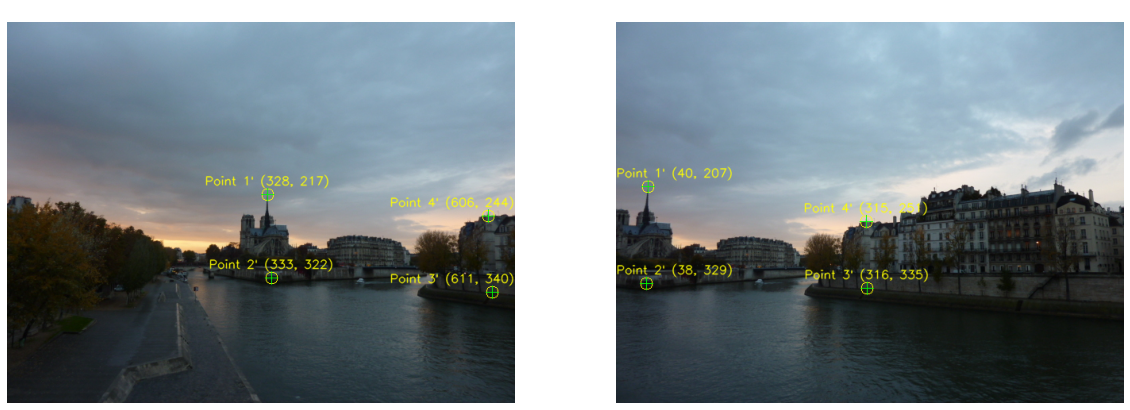

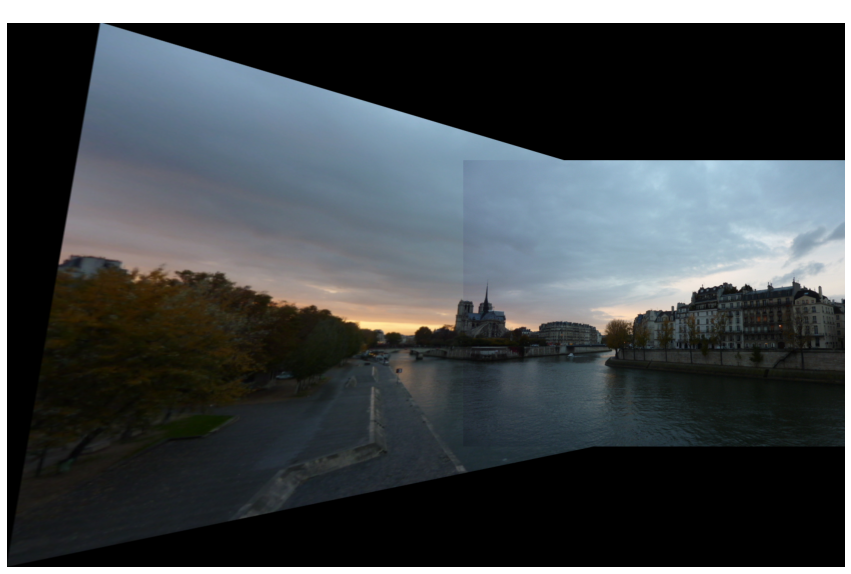

$$X_{init}=\begin{pmatrix}328 & 217\\333 & 322\\611 & 340\\606 & 244\\\end{pmatrix}$$

$$X_{final}=\begin{pmatrix}40 & 207\\38 & 329\\316 & 335\\315 & 251\\\end{pmatrix}$$

$$\mathcal{H}\approx\begin{pmatrix}2.13 & -0.14 & -607.6\\0.54 & 1.73 & -230.44\\0.0 & -0.0 & 1.0\\\end{pmatrix}$$

In [7]:
# Création de panorama à partir de deux images
# Clic gauche pour sélectionner les points sur les images
# Clic droit pour réinitialiser la sélection
# Entrée ou 'q' pour valider la sélection
# Echap pour annuler l'opération
panorama_maker.open_and_create_panorama("paris_a.jpg", "paris_b.jpg")